# Engine Evaluation

***
#### Importing Dependencies

In [1]:
# Importing Dependencies
from epl_metrics import evaluate_engine_performance
from epl_datasets import load_data

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import yaml

In [2]:
sns.set(font_scale = 1.2, style = 'darkgrid', palette = 'bright')
warnings.filterwarnings(action = 'ignore')
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.display.max_columns = None
np.random.seed(seed = 42)

Let's load the yaml file.

In [3]:
# Loading the yaml file
with open(file = "../Configuration/config.yml") as yaml_file:
    config = yaml.safe_load(stream = yaml_file)

Let's load the yaml file and create global variables.

In [4]:
# Loading the current season
CURRENT_SEASON = config.get('current_season').replace('/', '-')

Let's call the function to load the data.

In [5]:
# Calling the function to load the dataset
df = load_data()

# Loading the test set
current_season_df = pd.read_parquet(path = f"../Data/Converted data/{CURRENT_SEASON}_season.parquet.brotli", engine = "fastparquet")

# Casting the data type of match date variable from object to datetime
current_season_df.match_date = pd.to_datetime(arg = current_season_df.match_date, yearfirst = True)

# Sorting the matches in ascending order
current_season_df = current_season_df.sort_values(by = "match_date").reset_index(drop = True)

# Concatenating the data frames
df = pd.concat(objs = [df, current_season_df], ignore_index = True)

# Displaying the first five records
df.head()

,season,match_week,match_date,month,day,weekday,referee,home_team,away_team,stadium,attendance,derby_name,club_tier_h,club_tier_a,h_position,a_position,streak_h,streak_a,goals_h,goals_a,possession_h,possession_a,shots_on_target_h,shots_on_target_a,shots_h,shots_a,touches_h,touches_a,passes_h,passes_a,tackles_h,tackles_a,clearances_h,clearances_a,corners_h,corners_a,offsides_h,offsides_a,yellow_cards_h,yellow_cards_a,red_cards_h,red_cards_a,fouls_conceded_h,fouls_conceded_a,result_h,result_a,points_h,points_a,n_epls_h,n_epls_a,n_ucls_h,n_ucls_a,total_n_matches_played_h,total_n_matches_played_a,total_max_points_h,total_max_points_a,total_points_h_cum,total_avg_acc_points_h,total_avg_points_accumulated_last_3_h,total_avg_points_accumulated_last_5_h,total_points_a_cum,total_avg_acc_points_a,total_avg_points_accumulated_last_3_a,total_avg_points_accumulated_last_5_a,total_points_dropped_h,total_avg_dropped_points_h,total_avg_points_dropped_last_3_h,total_avg_points_dropped_last_5_h,total_points_dropped_a,total_avg_dropped_points_a,total_avg_points_dropped_last_3_a,total_avg_points_dropped_last_5_a,total_goals_scored_h,total_avg_goals_scored_h,total_avg_goals_scored_last_3_h,total_avg_goals_scored_last_5_h,total_goals_scored_a,total_avg_goals_scored_a,total_avg_goals_scored_last_3_a,total_avg_goals_scored_last_5_a,total_goals_conceded_h,total_avg_goals_conceded_h,total_avg_goals_conceded_last_3_h,total_avg_goals_conceded_last_5_h,total_goals_conceded_a,total_avg_goals_conceded_a,total_avg_goals_conceded_last_3_a,total_avg_goals_conceded_last_5_a,total_avg_possession_h,total_avg_possession_a,total_avg_possession_last_3_h,total_avg_possession_last_3_a,total_avg_possession_last_5_h,total_avg_possession_last_5_a,total_shots_on_target_cum_h,total_shots_on_target_cum_a,total_avg_shots_on_target_h,total_avg_shots_on_target_a,total_avg_shots_on_target_last_3_h,total_avg_shots_on_target_last_3_a,total_avg_shots_on_target_last_5_h,total_avg_shots_on_target_last_5_a,total_shots_cum_h,total_shots_cum_a,total_avg_shots_h,total_avg_shots_a,total_avg_shots_last_3_h,total_avg_shots_last_3_a,total_avg_shots_last_5_h,total_avg_shots_last_5_a,total_avg_touches_h,total_avg_touches_a,total_avg_touches_last_3_h,total_avg_touches_last_3_a,total_avg_touches_last_5_h,total_avg_touches_last_5_a,total_avg_passes_h,total_avg_passes_a,total_avg_passes_last_3_h,total_avg_passes_last_3_a,total_avg_passes_last_5_h,total_avg_passes_last_5_a,total_avg_tackles_h,total_avg_tackles_a,total_avg_tackles_last_3_h,total_avg_tackles_last_3_a,total_avg_tackles_last_5_h,total_avg_tackles_last_5_a,total_avg_clearances_h,total_avg_clearances_a,total_avg_clearances_last_3_h,total_avg_clearances_last_3_a,total_avg_clearances_last_5_h,total_avg_clearances_last_5_a,total_avg_corners_h,total_avg_corners_a,total_avg_corners_last_3_h,total_avg_corners_last_3_a,total_avg_corners_last_5_h,total_avg_corners_last_5_a,total_avg_offsides_h,total_avg_offsides_a,total_avg_offsides_last_3_h,total_avg_offsides_last_3_a,total_avg_offsides_last_5_h,total_avg_offsides_last_5_a,total_avg_yellow_cards_h,total_avg_yellow_cards_a,total_avg_yellow_cards_last_3_h,total_avg_yellow_cards_last_3_a,total_avg_yellow_cards_last_5_h,total_avg_yellow_cards_last_5_a,total_avg_fouls_conceded_h,total_avg_fouls_conceded_a,total_avg_fouls_conceded_last_3_h,total_avg_fouls_conceded_last_3_a,total_avg_fouls_conceded_last_5_h,total_avg_fouls_conceded_last_5_a,total_s2g_cum_ratio_h,total_s2g_ratio_last_3_h,total_s2g_ratio_last_5_h,total_s2g_cum_ratio_a,total_s2g_ratio_last_3_a,total_s2g_ratio_last_5_a,total_s2s_cum_ratio_h,total_s2s_ratio_last_3_h,total_s2s_ratio_last_5_h,total_s2s_cum_ratio_a,total_s2s_ratio_last_3_a,total_s2s_ratio_last_5_a,n_matches_played_h,n_matches_played_a,max_points_h,max_points_a,points_h_cum,avg_acc_points_h,avg_points_accumulated_last_3_h,avg_points_accumulated_last_5_h,points_a_cum,avg_acc_points_a,avg_points_accumulated_last_3_a,avg_points_accumulated_last_5_a,points_dropped_h,avg_dropped_p

Let's call the function to make predictions on the entire dataset.

In [6]:
# Calling the function to  make predictions on the entire dataset
results_df = evaluate_engine_performance(input_df = df)

# Displaying the first five records
results_df.head()

,season,match_week,match_date,home_team,away_team,goals_h,goals_a,prediction,probability,confidence,output,bet,ground_truth
0,2006/07,1,2006-08-19,Bolton,Spurs,2,0,-1,0.47,Low,Probability of Spurs defeating Bolton away fro...,False,1
1,2006/07,1,2006-08-19,Reading,Middlesbrough,3,2,-1,0.39,Low,Probability of Middlesbrough defeating Reading...,False,1
2,2006/07,1,2006-08-19,Portsmouth,Blackburn,3,0,-1,0.42,Low,Probability of Blackburn defeating Portsmouth ...,False,1
3,2006/07,1,2006-08-19,Newcastle,Wigan,2,1,1,0.44,Low,Probability of Newcastle beating Wigan at home...,False,1
4,2006/07,1,2006-08-19,Everton,Watford,2,1,1,0.53,Medium,Probability of Everton beating Watford at home...,False,1


Let's visualize the performance of the engine per season using **accuracy score**.

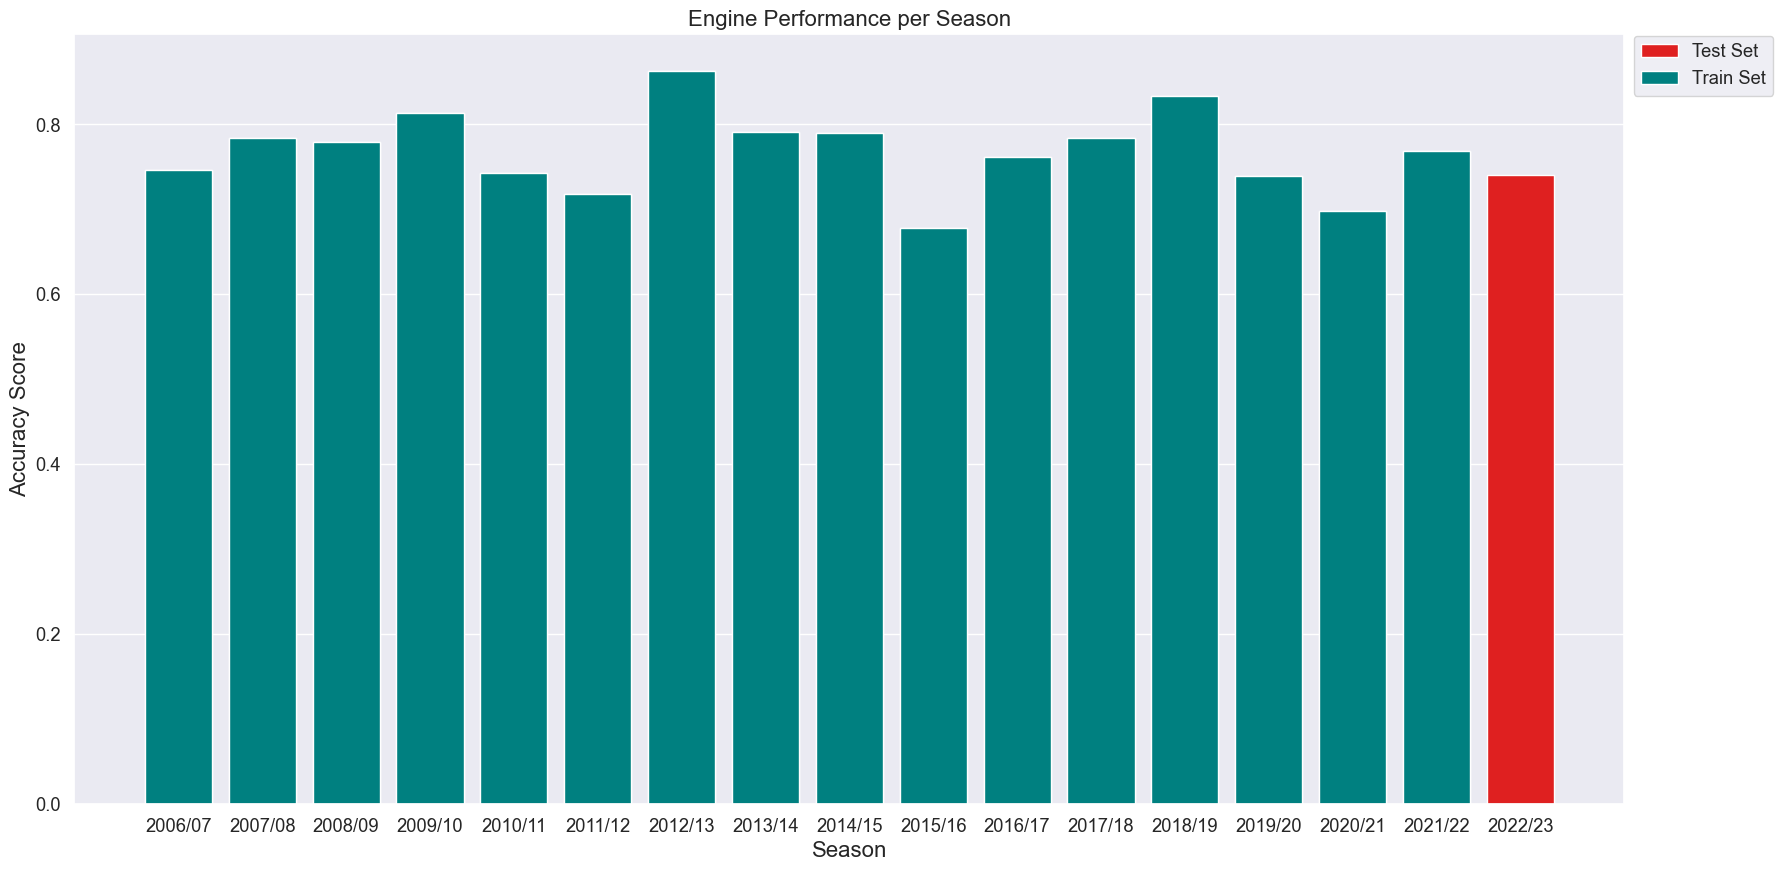

In [7]:
# Creating a list of seasons in ascending order
seasons = sorted(results_df.season.unique().tolist())

# Creating an empty list
accuracies = []

# Looping through each season
for season in seasons:
    # Storing the number of predictions with high confidence
    n_predictions = results_df.loc[(results_df.season == season) & 
                                   (results_df.confidence == "High")].shape[0]
    
    # Storing the number of correct predictions with high confidence
    n_correct_predictions = results_df.loc[(results_df.season == season) & 
                                           (results_df.confidence == "High") &
                                           (results_df.prediction == results_df.ground_truth)].shape[0]
    
    # Calculating the accuracy based on predictions with high confidence
    accuracy = n_correct_predictions / n_predictions
    
    # Appending the accuracy to the list
    accuracies.append(accuracy)

# Visualzing the engine performance for each season
plt.figure(figsize = (20, 10))
sns.barplot(x = seasons, y = accuracies, label = 'Test Set', color = 'red')
plt.bar(x = seasons[:-1], height = accuracies[:-1], label = 'Train Set', color = 'teal')
plt.title(label = 'Engine Performance per Season', fontsize = 16)
plt.ylabel(ylabel = 'Accuracy Score', fontsize = 16)
plt.xlabel(xlabel = 'Season', fontsize = 16)
plt.legend(bbox_to_anchor = (1, 1.01), loc = 'upper left')
plt.show()

Let's evaluate the performance of the engine on the train and the test set using **accuracy score**.

In [8]:
# Storing the number of predictions with high confidence for the train set
n_train_predictions = results_df.loc[(results_df.season != results_df.season.max()) &
                                     (results_df.confidence == "High")].shape[0]

# Storing the number of correct predictions with high confidence for the train set
n_train_correct_predictions = results_df.loc[(results_df.season != results_df.season.max()) &
                                             (results_df.confidence == "High") &
                                             (results_df.prediction == results_df.ground_truth)].shape[0]

# Storing the number of predictions with high confidence for the test set
n_test_predictions = results_df.loc[(results_df.season == results_df.season.max()) &
                                    (results_df.confidence == "High")].shape[0]

# Storing the number of correct predictions with high confidence for the test set
n_test_correct_predictions = results_df.loc[(results_df.season == results_df.season.max()) &
                                            (results_df.confidence == "High") &
                                            (results_df.prediction == results_df.ground_truth)].shape[0]

# Calculating the train and test set accuracy
train_accuracy = n_train_correct_predictions / n_train_predictions
test_accuracy = n_test_correct_predictions / n_test_predictions

# Printing out the engine's performance on the train and the test set
print(f"Engine's accuracy on the train set: {train_accuracy:.0%}")
print(f"Engine's accuracy on the test set: {test_accuracy:.0%}")

Engine's accuracy on the train set: 77%
Engine's accuracy on the test set: 74%


Let's write the engine predictions for the test set to a separate **csv** file. 

In [9]:
# Writing the engine predictions for the test set to a separate csv file
results_df.loc[(results_df.season == results_df.season.max()) &
               (results_df.confidence == "High")].reset_index(drop = True).to_csv(path_or_buf = "../Data/Predictions data/engine_predictions.csv", 
                                                                                  index = False)